# Invisible Labor

**Import Dependencies**

In [1]:
import pandas
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt

from sklearn import datasets
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.feature_selection import RFE
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

# Sets up seaborn for graphs to have grids
sns.set(color_codes=True)

Use this cell to import Toloka Data

In [2]:
# Reads in CSV, drops the first row with offset headings, sets new headings, and drops the two irrelevant columns
df_toloka = pd.read_csv("data/telemetry_db.csv")
df_toloka.drop(0)
df_toloka.columns = ['ID', 'Current', 'Event', 'Extra', 'Platform', 'Skip', 'Subtype', 'Time', 'Type', 'User', 'Irrelevant', 'Unused']
df_toloka = df_toloka.drop(columns=['Irrelevant', 'Unused'])

In [3]:
print(df_toloka.info())
df_toloka.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2894936 entries, 0 to 2894935
Data columns (total 10 columns):
 #   Column    Dtype  
---  ------    -----  
 0   ID        int64  
 1   Current   object 
 2   Event     object 
 3   Extra     object 
 4   Platform  object 
 5   Skip      float64
 6   Subtype   object 
 7   Time      float64
 8   Type      object 
 9   User      object 
dtypes: float64(2), int64(1), object(7)
memory usage: 220.9+ MB
None


,ID,Current,Event,Extra,Platform,Skip,Subtype,Time,Type,User
0,495553,https://toloka.yandex.com/task/31577897/0001e1...,PAGE_LOAD,NaN,TOLOKA,0.0,TASK_STARTED,1.290745e+12,WORKING,311ad54dd8763dd3365ea2342627aaf
1,1605885,https://toloka.yandex.com/tasks,TAB_CLOSED,NaN,TOLOKA,0.0,TASKS_LIST,1.351745e+12,SEARCHING,fd978fa116dde1ead273fa5fc7316697
2,0,https://toloka.yandex.com/tasks,PAGE_BLUR,NaN,TOLOKA,NaN,TASKS_LIST,1.642014e+12,SEARCHING,d75e96a84a13b15a1f6291c4c8df8b
3,0,https://sandbox.toloka.yandex.com/es/task/1083...,PAGE_FOCUS,NaN,TOLOKA,0.0,TASK_STARTED,1.642719e+12,WORKING,8d22505d156899a9e716e418221b2d10
4,1,https://sandbox.toloka.yandex.com/es/task/1083...,PAGE_FOCUS,NaN,TOLOKA,0.0,TASK_SUBMITED,1.642719e+12,WORKING,8d22505d156899a9e716e418221b2d10


# DATA CLEANING
- Toloka 'Extra' Column Removal

In [4]:
df_toloka = df_toloka.drop(columns=['Extra', 'Skip'])
df_toloka = df_toloka.dropna()
df_toloka.head()


,ID,Current,Event,Platform,Subtype,Time,Type,User
0,495553,https://toloka.yandex.com/task/31577897/0001e1...,PAGE_LOAD,TOLOKA,TASK_STARTED,1.290745e+12,WORKING,311ad54dd8763dd3365ea2342627aaf
1,1605885,https://toloka.yandex.com/tasks,TAB_CLOSED,TOLOKA,TASKS_LIST,1.351745e+12,SEARCHING,fd978fa116dde1ead273fa5fc7316697
2,0,https://toloka.yandex.com/tasks,PAGE_BLUR,TOLOKA,TASKS_LIST,1.642014e+12,SEARCHING,d75e96a84a13b15a1f6291c4c8df8b
3,0,https://sandbox.toloka.yandex.com/es/task/1083...,PAGE_FOCUS,TOLOKA,TASK_STARTED,1.642719e+12,WORKING,8d22505d156899a9e716e418221b2d10
4,1,https://sandbox.toloka.yandex.com/es/task/1083...,PAGE_FOCUS,TOLOKA,TASK_SUBMITED,1.642719e+12,WORKING,8d22505d156899a9e716e418221b2d10


### TOLOKA_SURVEY_DATA Cleaning

In [5]:
df_toloka_survey = pd.read_csv("data/toloka_survey_data.csv")
df_toloka_short = df_toloka_survey[['id', 'task_satisfaction', 'task_motivation',  'gender', 'age', 'current_country', 'home_country', 'only_one_country', 'education', 'group', 'freq_use', 'length_use', 'ability_find_tasks', 'promptly_find_tasks']].copy()
df_toloka_short = df_toloka_short.dropna()
df_toloka_short.head()

,id,task_satisfaction,task_motivation,gender,age,current_country,home_country,only_one_country,education,group,freq_use,length_use,ability_find_tasks,promptly_find_tasks
0,6f1753e09611df5751d6abe4b1ca2724,Strongly Disagree,5,Female,25-34 years old,Kenya,United States,No,Trade/technical/vocational training,treatment,From three to four days a week,Between 1 and 2 years,Agree,Strongly Agree
1,749c5a22d9ea6f818cd2c8bef8fb2c,Strongly Agree,5,Female,25-34 years old,Nigeria,Nigeria,No,Bachelor’s degree,treatment,Everyday,Between 1 and 3 months,Strongly Agree,Strongly Agree
2,27fab4b7ccdc585dc35897de76e44a8c,Slightly Agree,5,Male,18-24 years old,Pakistan,Pakistan,Yes,Bachelor’s degree,treatment,From three to four days a week,Between 3 and 6 months,Neutral,Agree
3,356cd2c5f07830925f6a46ee42e9c748,Slightly Agree,5,Female,18-24 years old,Brazil,Brazil,Yes,"High school graduate, diploma or the equivalen...",treatment,Everyday,More than 2 and 3 years,Strongly Agree,Strongly Agree
4,25daec93559c8d639738bb2c2d8f3194,Neutral,5,Male,25-34 years old,Brazil,Brazil,Yes,"High school graduate, diploma or the equivalen...",treatment,Everyday,Between 3 and 6 months,Neutral,Disagree


Text(0.5, 0, 'Workers')

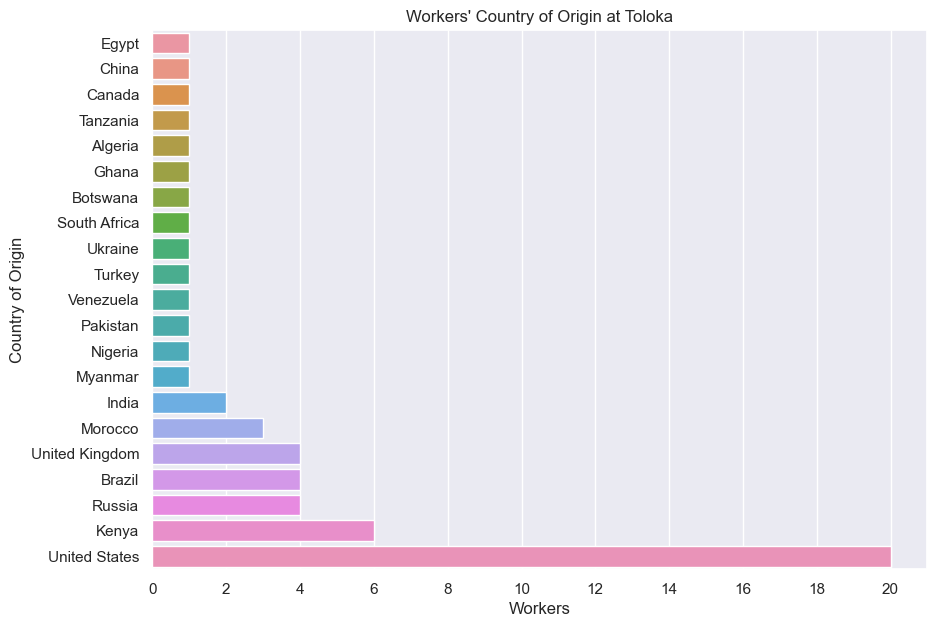

In [6]:
fig, ax_tolo = plt.subplots(1, 1, figsize=(10, 7))
# ax_tolo = sns.countplot(y="home_country", data=df_toloka_short)
ax_tolo = sns.countplot(y="current_country", data=df_toloka_short, order=df_toloka_short['current_country'].value_counts(ascending=True).index)
ax_tolo.set_title("Workers' Country of Origin at Toloka")
ax_tolo.set_xticks(np.arange(0, 21, 2))
ax_tolo.set_ylabel("Country of Origin")
ax_tolo.set_xlabel("Workers")

Text(0.5, 0, 'Workers')

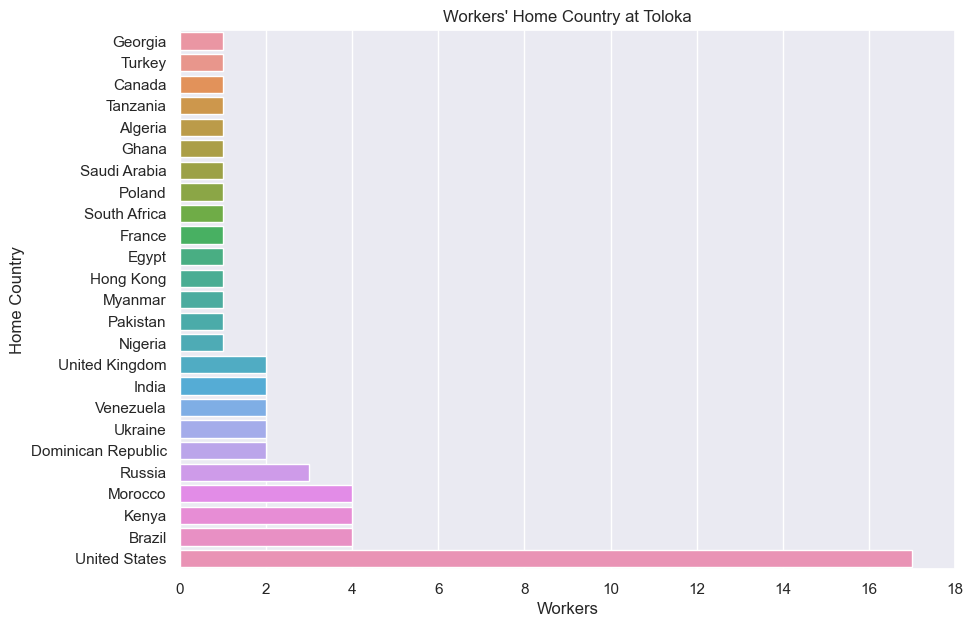

In [7]:
fig, ax_tolo = plt.subplots(1, 1, figsize=(10, 7))
ax_tolo = sns.countplot(y="home_country", data=df_toloka_short, order=df_toloka_short['home_country'].value_counts(ascending=True).index)
ax_tolo.set_title("Workers' Home Country at Toloka")
ax_tolo.set_xticks(np.arange(0, 19, 2))
ax_tolo.set_ylabel("Home Country")
ax_tolo.set_xlabel("Workers")

In [8]:
df_toloka_short = df_toloka_short.rename(columns={'id': 'User'})
merged_toloka = pd.merge(df_toloka, df_toloka_short, on='User', how='left')
merged_toloka = merged_toloka.dropna()
merged_toloka

,ID,Current,Event,Platform,Subtype,Time,Type,User,task_satisfaction,task_motivation,...,age,current_country,home_country,only_one_country,education,group,freq_use,length_use,ability_find_tasks,promptly_find_tasks
1471,1493,chrome://general,CONFIG_FILE,OTHER,GENERAL,1.642803e+12,API,6f1753e09611df5751d6abe4b1ca2724,Strongly Disagree,5.0,...,25-34 years old,Kenya,United States,No,Trade/technical/vocational training,treatment,From three to four days a week,Between 1 and 2 years,Agree,Strongly Agree
1472,1494,chrome://general,CONFIG_FILE,OTHER,GENERAL,1.642803e+12,API,6f1753e09611df5751d6abe4b1ca2724,Strongly Disagree,5.0,...,25-34 years old,Kenya,United States,No,Trade/technical/vocational training,treatment,From three to four days a week,Between 1 and 2 years,Agree,Strongly Agree
1473,1495,chrome://appinstall,PLUGIN_INSTALL,OTHER,OTHER,1.642803e+12,OTHER,6f1753e09611df5751d6abe4b1ca2724,Strongly Disagree,5.0,...,25-34 years old,Kenya,United States,No,Trade/technical/vocational training,treatment,From three to four days a week,Between 1 and 2 years,Agree,Strongly Agree
1474,1496,chrome://general,CONFIG_FILE,OTHER,GENERAL,1.642803e+12,API,6f1753e09611df5751d6abe4b1ca2724,Strongly Disagree,5.0,...,25-34 years old,Kenya,United States,No,Trade/technical/vocational training,treatment,From three to four days a week,Between 1 and 2 years,Agree,Strongly Agree
1483,1505,https://toloka.yandex.com/task/31173702/0001db...,TAB_CHANGE,TOLOKA,TASK_STARTED,1.642803e+12,WORKING,6f1753e09611df5751d6abe4b1ca2724,Strongly Disagree,5.0,...,25-34 years old,Kenya,United States,No,Trade/technical/vocational training,treatment,From three to four days a week,Between 1 and 2 years,Agree,Strongly Agree
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2894827,1637343,https://account.skrill.com/wallet/account/logi...,TAB_CHANGE,OTHER,OTHER,1.650931e+12,OTHER,749c5a22d9ea6f818cd2c8bef8fb2c,Strongly Agree,5.0,...,25-34 years old,Nigeria,Nigeria,No,Bachelor’s degree,treatment,Everyday,Between 1 and 3 months,Strongly Agree,Strongly Agree
2894828,1637377,chrome://userdata,USER,OTHER,META_DATA,1.650931e+12,API,749c5a22d9ea6f818cd2c8bef8fb2c,Strongly Agree,5.0,...,25-34 years old,Nigeria,Nigeria,No,Bachelor’s degree,treatment,Everyday,Between 1 and 3 months,Strongly Agree,Strongly Agree
2894829,1637426,chrome://userdata,USER,OTHER,META_DATA,1.650931e+12,API,749c5a22d9ea6f818cd2c8bef8fb2c,Strongly Agree,5.0,...,25-34 years old,Nigeria,Nigeria,No,Bachelor’s degree,treatment,Everyday,Between 1 and 3 months,Strongly Agree,Strongly Agree
2894830,1637498,chrome://configupdate,CONFIG_UPDATE,OTHER,SYSTEM,1.650931e+12,CONFIG,749c5a22d9ea6f818cd2c8bef8fb2c,Strongly Agree,5.0,...,25-34 years old,Nigeria,Nigeria,No,Bachelor’s degree,treatment,Everyday,Between 1 and 3 months,Strongly Agree,Strongly Agree


In [9]:
df_tolo_model_unlabeled = merged_toloka.drop(columns=['Current', 'ID', 'User', 'current_country', 'only_one_country', 'group', 'task_satisfaction', 'task_motivation'])
df_tolo_model_unlabeled

,Event,Platform,Subtype,Time,Type,gender,age,home_country,education,freq_use,length_use,ability_find_tasks,promptly_find_tasks
1471,CONFIG_FILE,OTHER,GENERAL,1.642803e+12,API,Female,25-34 years old,United States,Trade/technical/vocational training,From three to four days a week,Between 1 and 2 years,Agree,Strongly Agree
1472,CONFIG_FILE,OTHER,GENERAL,1.642803e+12,API,Female,25-34 years old,United States,Trade/technical/vocational training,From three to four days a week,Between 1 and 2 years,Agree,Strongly Agree
1473,PLUGIN_INSTALL,OTHER,OTHER,1.642803e+12,OTHER,Female,25-34 years old,United States,Trade/technical/vocational training,From three to four days a week,Between 1 and 2 years,Agree,Strongly Agree
1474,CONFIG_FILE,OTHER,GENERAL,1.642803e+12,API,Female,25-34 years old,United States,Trade/technical/vocational training,From three to four days a week,Between 1 and 2 years,Agree,Strongly Agree
1483,TAB_CHANGE,TOLOKA,TASK_STARTED,1.642803e+12,WORKING,Female,25-34 years old,United States,Trade/technical/vocational training,From three to four days a week,Between 1 and 2 years,Agree,Strongly Agree
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2894827,TAB_CHANGE,OTHER,OTHER,1.650931e+12,OTHER,Female,25-34 years old,Nigeria,Bachelor’s degree,Everyday,Between 1 and 3 months,Strongly Agree,Strongly Agree
2894828,USER,OTHER,META_DATA,1.650931e+12,API,Female,25-34 years old,Nigeria,Bachelor’s degree,Everyday,Between 1 and 3 months,Strongly Agree,Strongly Agree
2894829,USER,OTHER,META_DATA,1.650931e+12,API,Female,25-34 years old,Nigeria,Bachelor’s degree,Everyday,Between 1 and 3 months,Strongly Agree,Strongly Agree
2894830,CONFIG_UPDATE,OTHER,SYSTEM,1.650931e+12,CONFIG,Female,25-34 years old,Nigeria,Bachelor’s degree,Everyday,Between 1 and 3 months,Strongly Agree,Strongly Agree


In [10]:
from sklearn.preprocessing import LabelEncoder

df_tolo_model = pd.DataFrame(df_tolo_model_unlabeled)

Encoders = {}
Encoders['Event'] = LabelEncoder()
df_tolo_model['Event'] = Encoders['Event'].fit_transform(df_tolo_model['Event'])
Encoders['Platform'] = LabelEncoder()
df_tolo_model['Platform'] = Encoders['Platform'].fit_transform(df_tolo_model['Platform'])
Encoders['Subtype'] = LabelEncoder()
df_tolo_model['Subtype'] = Encoders['Subtype'].fit_transform(df_tolo_model['Subtype'])
Encoders['Type'] = LabelEncoder()
df_tolo_model['Type'] = Encoders['Type'].fit_transform(df_tolo_model['Type'])

# Encoders['task_satisfaction'] = LabelEncoder()
# df_tolo_model['task_satisfaction'] = Encoders['task_satisfaction'].fit_transform(df_tolo_model['task_satisfaction'])
Encoders['gender'] = LabelEncoder()
df_tolo_model['gender'] = Encoders['gender'].fit_transform(df_tolo_model['gender'])
Encoders['age'] = LabelEncoder()
df_tolo_model['age'] = Encoders['age'].fit_transform(df_tolo_model['age'])
# Encoders['current_country'] = LabelEncoder()
# df_tolo_model['current_country'] = Encoders['current_country'].fit_transform(df_tolo_model['current_country'])
Encoders['home_country'] = LabelEncoder()
df_tolo_model['home_country'] = Encoders['home_country'].fit_transform(df_tolo_model['home_country'])
# Encoders['only_one_country'] = LabelEncoder()
# df_tolo_model['only_one_country'] = Encoders['only_one_country'].fit_transform(df_tolo_model['only_one_country'])
Encoders['education'] = LabelEncoder()
df_tolo_model['education'] = Encoders['education'].fit_transform(df_tolo_model['education'])
# Encoders['group'] = LabelEncoder()
# df_tolo_model['group'] = Encoders['group'].fit_transform(df_tolo_model['group'])

Encoders['freq_use'] = LabelEncoder()
df_tolo_model['freq_use'] = Encoders['freq_use'].fit_transform(df_tolo_model['freq_use'])
Encoders['length_use'] = LabelEncoder()
df_tolo_model['length_use'] = Encoders['length_use'].fit_transform(df_tolo_model['length_use'])
Encoders['ability_find_tasks'] = LabelEncoder()
df_tolo_model['ability_find_tasks'] = Encoders['ability_find_tasks'].fit_transform(df_tolo_model['ability_find_tasks'])
Encoders['promptly_find_tasks'] = LabelEncoder()
df_tolo_model['promptly_find_tasks'] = Encoders['promptly_find_tasks'].fit_transform(df_tolo_model['promptly_find_tasks'])

print(df_tolo_model.info())

<class 'pandas.core.frame.DataFrame'>
Index: 842807 entries, 1471 to 2894831
Data columns (total 13 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   Event                842807 non-null  int32  
 1   Platform             842807 non-null  int32  
 2   Subtype              842807 non-null  int32  
 3   Time                 842807 non-null  float64
 4   Type                 842807 non-null  int32  
 5   gender               842807 non-null  int32  
 6   age                  842807 non-null  int32  
 7   home_country         842807 non-null  int32  
 8   education            842807 non-null  int32  
 9   freq_use             842807 non-null  int32  
 10  length_use           842807 non-null  int32  
 11  ability_find_tasks   842807 non-null  int32  
 12  promptly_find_tasks  842807 non-null  int32  
dtypes: float64(1), int32(12)
memory usage: 51.4 MB
None


In [11]:
target_df = df_tolo_model['home_country']
data_df = df_tolo_model.drop(columns=['home_country'])

target_df = target_df.iloc[150000:180000]
data_df = data_df.iloc[150000:180000]

scale = MinMaxScaler()

data_df = pd.DataFrame(scale.fit_transform(data_df), columns=data_df.columns)

Xtrain, Xtest, Ytrain, Ytest = train_test_split(data_df, target_df, test_size=0.20, random_state=50)
Xtrain, Xval, Ytrain, Yval = train_test_split(Xtrain, Ytrain, test_size=0.20, random_state=50)
data_df

,Event,Platform,Subtype,Time,Type,gender,age,education,freq_use,length_use,ability_find_tasks,promptly_find_tasks
0,0.344828,1.0,0.545455,0.000000e+00,0.7,1.0,0.5,0.500000,1.00,0.4,0.00,0.000000
1,0.793103,0.0,0.409091,2.369325e-08,0.4,1.0,0.0,0.000000,0.00,0.6,0.50,0.333333
2,0.000000,0.0,0.409091,3.366949e-08,0.4,1.0,0.5,0.500000,1.00,0.4,0.00,0.000000
3,0.448276,1.0,0.545455,1.030040e-06,0.7,1.0,0.5,0.500000,1.00,0.4,0.00,0.000000
4,0.551724,1.0,0.545455,2.673616e-06,0.7,1.0,0.5,0.500000,1.00,0.4,0.00,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...
29995,0.793103,0.0,0.409091,9.999459e-01,0.4,1.0,0.0,0.500000,0.00,0.6,0.75,1.000000
29996,0.793103,0.0,0.409091,9.999603e-01,0.4,1.0,0.0,0.500000,0.00,0.6,0.75,1.000000
29997,0.965517,1.0,0.000000,9.999789e-01,0.3,1.0,0.5,0.666667,0.25,0.2,0.50,0.666667
29998,0.827586,0.0,0.409091,9.999970e-01,0.4,1.0,0.0,0.500000,0.00,0.6,0.75,1.000000


In [12]:
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge
models = [
    ('log', LogisticRegression(max_iter=1000)),
    ('svc', SVC()),
    ('ridge', Ridge()),
    ('lasso', Lasso())
    
]

In [13]:
params = {
    'log': {'C': [0.1, 1.0, 10.0]},
    'svc': {'C': [0.1, 1.0, 10.0], 'kernel': ['linear', 'rbf']},
    'ridge': {'alpha': [0.1, 1.0, 10.0]},
    'lasso': {'alpha': [0.1, 1.0, 10.0]}
}

In [14]:
from sklearn.model_selection import KFold
best = None
bestAc = 0.0
n_splits = 5
kf = KFold(n_splits=n_splits)

for name, model in models:
    search = GridSearchCV(model, params[name], cv=kf, n_jobs=-1)
    search.fit(Xtrain, Ytrain)
    accuracy = search.score(Xval, Yval)
    if accuracy > bestAc:
        best = search.best_estimator_
        bestAc = accuracy
    print(f"{name} valid accuracy = {accuracy}")

log valid accuracy = 0.97125
svc valid accuracy = 0.9729166666666667
ridge valid accuracy = 0.36046864089934083
lasso valid accuracy = 0.3227152017273076


In [15]:
from sklearn.metrics import accuracy_score

test = accuracy_score(Ytest, best.predict(Xtest))
print(f"Best model = ({type(best).__name__}) accuracy = {test}")

Best model = (SVC) accuracy = 0.9766666666666667


------------------------------------------------------------------------------------------
Predictions based on a small section of the dataset, and then guessing additional values. 
Then the dataset is checked for accuracy.
------------------------------------------------------------------------------------------

In [16]:
# Predict using the "best" model picked earlier
y_pred = best.predict(Xtest)
print("Dataset score using Test Data: ", best.score(Xtest, Ytest))
print("Dataset score using Val Data: ", best.score(Xval, Yval))

# Print out Mean Squared Error for predicted data and the data in the test set
print("Mean Squared Error between predicted data and test set: ", mean_squared_error(y_pred, Ytest))

Dataset score using Test Data:  0.9766666666666667
Dataset score using Val Data:  0.9729166666666667
Mean Squared Error between predicted data and test set:  9.333333333333334


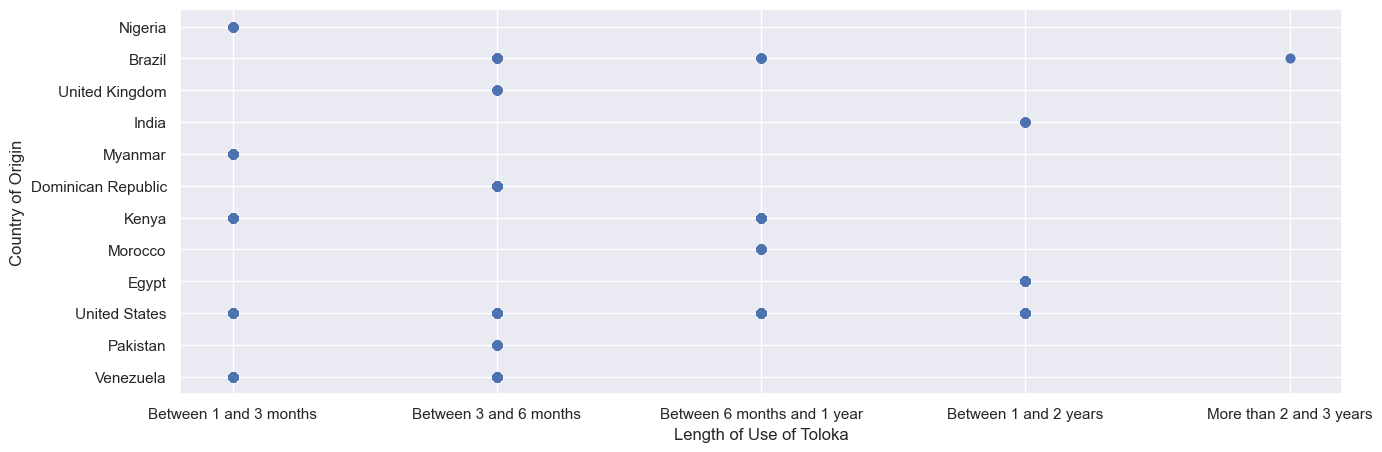

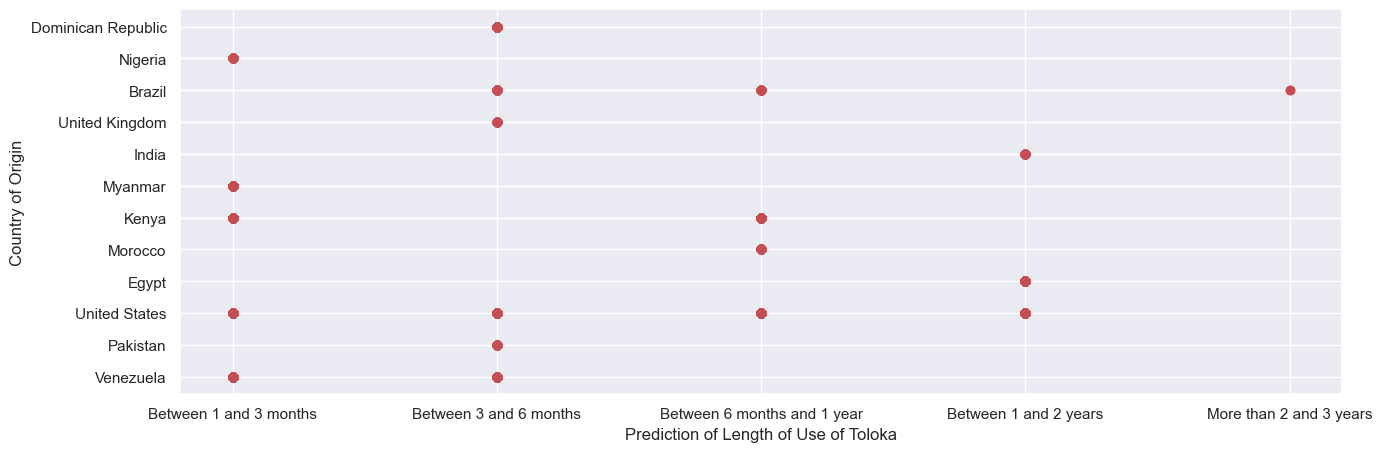

In [17]:
#Inverts Scale and Encoding for the X test predictor length_use
X_length_use = pd.DataFrame(scale.inverse_transform(Xtest), columns=Xtest.columns)
X_length_use['length_use'] = X_length_use['length_use'].astype(int)
X_length_use = Encoders['length_use'].inverse_transform(X_length_use['length_use'])

#Inverts Encoding for the target home_country for the Test and Prediction
y_test = Encoders['home_country'].inverse_transform(Ytest)
y_predict = Encoders['home_country'].inverse_transform(y_pred)

#Original Test Values
fig, ax = plt.subplots(1, 1, figsize=(15, 5))
ax.scatter(X_length_use, y_test)
ax.set_ylabel("Country of Origin")
ax.set_xlabel("Length of Use of Toloka")
plt.show()

#Prediction
fig, ax = plt.subplots(1, 1, figsize=(15, 5))
ax.scatter(X_length_use, y_predict, color='r')
ax.set_ylabel("Country of Origin")
ax.set_xlabel("Prediction of Length of Use of Toloka")
plt.show()

In [18]:
# from sklearn.model_selection import train_test_split
# from sklearn.metrics import classification_report, confusion_matrix
# import seaborn as sns
# # Split data into train and test sets
# # Xtrain, Xtest, Ytrain, Ytest = train_test_split(data_df, target_df, test_size=0.2, random_state=42)

# # Perform another split for validation if needed
# # Xtrain, Xval, Ytrain, Yval = train_test_split(Xtrain, Ytrain, test_size=0.25, random_state=42)  # 0.25 x 0.8 = 0.2

# # Model training
# rf_classifier = RandomForestClassifier()
# rf_classifier.fit(Xtrain, Ytrain)

# # Model evaluation
# y_pred = rf_classifier.predict(Xtest)
# print(classification_report(Ytest, y_pred))

# # Confusion matrix
# conf_matrix = confusion_matrix(Ytest, y_pred)
# sns.heatmap(conf_matrix, annot=True, fmt='d')
# plt.xlabel('Predicted')
# plt.ylabel('True')
# plt.show()

# import matplotlib.pyplot as plt

# # Plot predicted and actual values
# plt.figure(figsize=(10, 5))
# plt.plot(Ytest, label='Actual', color='blue')
# plt.plot(y_pred, label='Predicted', color='red')
# plt.title('Actual vs Predicted Values')
# plt.xlabel('Sample')
# plt.ylabel('Value')
# plt.legend()
# plt.grid(True)
# plt.show()

In [19]:
# import numpy as np
# import matplotlib.pyplot as plt
# from scipy.stats import pearsonr

# # Plot predicted vs actual values
# plt.figure(figsize=(10, 5))
# plt.scatter(Ytest, y_pred, color='blue')
# plt.title('Predicted vs Actual Values')
# plt.xlabel('Actual Values')
# plt.ylabel('Predicted Values')
# plt.grid(True)
# plt.show()

# # Calculate correlation coefficient (r value)
# r, _ = pearsonr(Ytest, y_pred)
# print("Correlation Coefficient (r value):", r)

In [20]:
# # Assuming you have trained your model and made predictions
# # Make sure you replace `predicted_country` and `actual_country` with your actual predicted and actual country values

# # Plot predicted vs actual country of origin
# plt.figure(figsize=(10, 7))
# plt.plot(predicted_country, label='Predicted', color='red', marker='o', linestyle='-')
# plt.plot(actual_country, label='Actual', color='blue', marker='x', linestyle='--')
# plt.title("Predicted vs Actual Country of Origin")
# plt.xlabel("Samples")
# plt.ylabel("Country")
# plt.legend()
# plt.grid(True)
# plt.show()
